# **Capstone 2 - West Nile Virus Prediction**<br>

West Nile virus (WNV), according to [Centers for Disease Control & Prevention (CDC)](https://www.cdc.gov/westnile/index.html#:~:text=West%20Nile%20virus%20(WNV)%20is,summer%20and%20continues%20through%20fall.), is the leading cause of mosquito-borne disease in the continental United States.  It is most commonly spread to people by the bite of an infected mosquito. WNV usually occurs during mosquito seasons in summer and fall. There are no vaccines to prevent or medications to treat WNV in people.<br>



**The Problem Statement:**

The objective of this project is to analyze the data provided, build a model and predict if WNV is present at a location in Chicago. 

In [139]:
#!pip install geopandas
#!pip install shap

In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_roc_curve, precision_score
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
import shap

## **0) Loading the Data**

Downloading Data from Kaggle into Colab

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
#! pip install -q kaggle

In [143]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data'
#changing the working directory 
#%cd /content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data

# Kaggle API command for the dataset
#! kaggle competitions download -c 'predict-west-nile-virus'

In [144]:
#check content in the directory
#!ls

In [145]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

Checking the initial content of the data

In [146]:
#Establish the data directory
mapdata_txt = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data/mapdata_copyright_openstreetmap_contributors.txt'
spray_org = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data/spray.csv'
test_org = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data/test.csv'
train_org = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data/train.csv'
weather_org = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data/weather.csv'

In [147]:
#train data
train_raw = pd.read_csv(train_org, parse_dates=['Date'])
train_raw.head(2).T

,0,1
Date,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,..."
Species,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
Block,41,41
Street,N OAK PARK AVE,N OAK PARK AVE
Trap,T002,T002
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL"
Latitude,41.9547,41.9547
Longitude,-87.801,-87.801
AddressAccuracy,9,9


In [148]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

In [149]:
#weather data
weather_raw = pd.read_csv(weather_org, parse_dates=['Date'])
weather_raw.head(2).T

,0,1
Station,1,2
Date,2007-05-01 00:00:00,2007-05-01 00:00:00
Tmax,83,84
Tmin,50,52
Tavg,67,68
Depart,14,M
DewPoint,51,51
WetBulb,56,57
Heat,0,0
Cool,2,3


In [150]:
weather_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [151]:
train_raw.shape, weather_raw.shape

((10506, 12), (2944, 22))

## **1) Understanding the Data & Data Cleaning**




According to National Center for Biotechnology Information, [Culex mosquitoes](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3485754/) are accepted as the primary global transmission vector. <br>

Comprhensively, these are the mosquito breeds identified by CDC which could cause WNV - 
https://www.cdc.gov/westnile/resources/pdfs/MosquitoSpecies1999-2016.pdf

A few other facts in relation to Culex mosquitoes according to [CDC](https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html):


*   It takes 7-10 days for a Culex mosquito egg to develop into an adult Culex mosquito
*   Adult female mosquitos usually lay eggs in fresh or stagnant water, including barrels, unmaintained swimming pools, puddles, creaks, marsh areas
*   Once an adult turned from pupa, it flies away. Their flying distance is up to 2 miles (or 3.2 km)
*   According to [Pestworld](https://www.pestworld.org/pest-guide/mosquitoes/culex-mosquitoes/#:~:text=Culex%20mosquitoes%20are%20usually%20about,active%20at%20dawn%20and%20dusk.), they are most active at dawn or dusk







From the types of mosquitos identified in the dataset, basically all could contributed to WNV. Culex Pipens or Restuans were the most prevailing types of moquitos trapped.



## **1.1) The Training Data**




In [152]:
#understanding the date range of the training data
train_raw['Date'].min(), train_raw['Date'].max()

(Timestamp('2007-05-29 00:00:00'), Timestamp('2013-09-26 00:00:00'))

In [153]:
#if there are null values in the training data
train_raw.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [154]:
#check for duplicated columns - defined as all records in the row is identical
train_raw_duplicated = train_raw[train_raw.duplicated()].value_counts().sum()
total_records = train_raw.index.value_counts().sum()
print(f'Total number of records: {total_records}')
print(f'Number of duplicated rows: {train_raw_duplicated}')
print(f'Percentage of duplicated records: {train_raw_duplicated/ total_records*100:.2f}%')

Total number of records: 10506
Number of duplicated rows: 813
Percentage of duplicated records: 7.74%


In [155]:
#dropping duplicated columns - keeping last records
train_raw = train_raw.drop_duplicates(subset=None, keep='first', inplace=False)

In [156]:
print(f'Total number of records after dropping duplicates: {train_raw.shape[0]}')

Total number of records after dropping duplicates: 9693


In [157]:
# adding year and month column for future EDA
train_raw['Year'] = train_raw['Date'].dt.year
train_raw['Year-Month'] = train_raw['Date'].dt.to_period('M')
train_raw['Year-Week'] = train_raw['Date'].dt.to_period('W')
#train_raw['Year-Week'] = train_raw['Date'].dt.strftime('%Y-%W')
train_raw.head(2).T

,0,1
Date,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"4100 North Oak Park Avenue, Chicago, IL 60634,...","4100 North Oak Park Avenue, Chicago, IL 60634,..."
Species,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
Block,41,41
Street,N OAK PARK AVE,N OAK PARK AVE
Trap,T002,T002
AddressNumberAndStreet,"4100 N OAK PARK AVE, Chicago, IL","4100 N OAK PARK AVE, Chicago, IL"
Latitude,41.9547,41.9547
Longitude,-87.801,-87.801
AddressAccuracy,9,9


In [158]:
#merging rows with mosquitos in the trap > 50
train_grouped = train_raw.groupby(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy', 'WnvPresent',
       'Year', 'Year-Month', 'Year-Week'])['NumMosquitos'].sum().reset_index()
train_grouped.head(2)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,WnvPresent,Year,Year-Month,Year-Week,NumMosquitos
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,2007,2007-05,2007-05-28/2007-06-03,1
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,2007,2007-05,2007-05-28/2007-06-03,2


In [159]:
train_grouped.shape

(8610, 15)

## **1.2) The Weather Data**




In [160]:
#understanding the date range of the weather data
weather_raw['Date'].min(), weather_raw['Date'].max()

(Timestamp('2007-05-01 00:00:00'), Timestamp('2014-10-31 00:00:00'))

In [161]:
#if there are null values in the weather data
weather_raw.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [162]:
#check for duplicated columns - defined as all records in the row is identical
weather_raw_duplicated = weather_raw[weather_raw.duplicated()].value_counts().sum()
print(f'Number of duplicated rows: {weather_raw_duplicated}')

Number of duplicated rows: 0


In [163]:
weather_raw.shape

(2944, 22)

In [164]:
#check for missing data where value 'M' identified in a column
weather_raw.isin(['M']).sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

As there are two different weather stations, checking to see if the dataset differs if being split by stations.

In [165]:
station_1 = weather_raw[weather_raw['Station']==1]
station_2 = weather_raw[weather_raw['Station']==2]

In [166]:
station_1.isin(['M']).sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg              0
Depart            0
DewPoint          0
WetBulb           3
Heat              0
Cool              0
Sunrise           0
Sunset            0
CodeSum           0
Depth             0
Water1         1472
SnowFall          0
PrecipTotal       0
StnPressure       2
SeaLevel          5
ResultSpeed       0
ResultDir         0
AvgSpeed          0
dtype: int64

In [167]:
station_2.isin(['M']).sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           1
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         1472
SnowFall       1472
PrecipTotal       2
StnPressure       2
SeaLevel          4
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

Most items missing in station 2 exists in station one, for filling in missing data, suggesting to bring forward info already existed in station 1 by forward fill. First step will require cleaning missing data under station 1.

In [168]:
station_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 2942
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      1472 non-null   int64         
 1   Date         1472 non-null   datetime64[ns]
 2   Tmax         1472 non-null   int64         
 3   Tmin         1472 non-null   int64         
 4   Tavg         1472 non-null   object        
 5   Depart       1472 non-null   object        
 6   DewPoint     1472 non-null   int64         
 7   WetBulb      1472 non-null   object        
 8   Heat         1472 non-null   object        
 9   Cool         1472 non-null   object        
 10  Sunrise      1472 non-null   object        
 11  Sunset       1472 non-null   object        
 12  CodeSum      1472 non-null   object        
 13  Depth        1472 non-null   object        
 14  Water1       1472 non-null   object        
 15  SnowFall     1472 non-null   object        
 16  Precip

In [169]:
# filling in missing value from station 1
station_1['WetBulb'] = station_1['WetBulb'].replace('M',0).astype(float)
station_1['StnPressure'] = station_1['StnPressure'].replace('M',0).astype(float)
station_1['SeaLevel'] = station_1['SeaLevel'].replace('M',0).astype(float)

#clean up - in sunrise/ sunset column
weather_raw['Sunrise'] = weather_raw['Sunrise'].replace('-', np.nan)
weather_raw['Sunset'] = weather_raw['Sunset'].replace('-', np.nan)

#clean up "Trace" amount in the data for PrecipTotal
weather_raw['PrecipTotal'] = weather_raw['PrecipTotal'].replace('M', 0)
weather_raw['PrecipTotal'] = weather_raw['PrecipTotal'].replace('  T', 0.01)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [170]:
# replace M for missing values to NaN
weather_raw = weather_raw.replace('M', np.nan)

In [171]:
# forward fill missing values from station 1
weather_raw = weather_raw.ffill(axis=1)

In [172]:
#dropping columns Depth, Snowfall related data and CodeSum for now
weather = weather_raw.drop(['Depth', 'Water1', 'SnowFall', 'CodeSum'], axis=1)

In [173]:
# changing dtype from object to float
column_headers = weather.select_dtypes(include='object').columns.tolist()

for header in column_headers:
  weather[header] = weather[header].astype(float)

In [174]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   float64       
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   float64       
 3   Tmin         2944 non-null   float64       
 4   Tavg         2944 non-null   float64       
 5   Depart       2944 non-null   float64       
 6   DewPoint     2944 non-null   float64       
 7   WetBulb      2944 non-null   float64       
 8   Heat         2944 non-null   float64       
 9   Cool         2944 non-null   float64       
 10  Sunrise      2944 non-null   float64       
 11  Sunset       2944 non-null   float64       
 12  PrecipTotal  2944 non-null   float64       
 13  StnPressure  2944 non-null   float64       
 14  SeaLevel     2944 non-null   float64       
 15  ResultSpeed  2944 non-null   float64       
 16  Result

In [175]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1.0,2007-05-01,83.0,50.0,67.0,14.0,51.0,56.0,0.0,2.0,448.0,1849.0,0.0,29.10,29.82,1.7,27.0,9.2
1,2.0,2007-05-01,84.0,52.0,68.0,68.0,51.0,57.0,0.0,3.0,3.0,3.0,0.0,29.18,29.82,2.7,25.0,9.6
2,1.0,2007-05-02,59.0,42.0,51.0,-3.0,42.0,47.0,14.0,0.0,447.0,1850.0,0.0,29.38,30.09,13.0,4.0,13.4
3,2.0,2007-05-02,60.0,43.0,52.0,52.0,42.0,47.0,13.0,0.0,0.0,0.0,0.0,29.44,30.08,13.3,2.0,13.4
4,1.0,2007-05-03,66.0,46.0,56.0,2.0,40.0,48.0,9.0,0.0,446.0,1851.0,0.0,29.39,30.12,11.7,7.0,11.9


In [176]:
#averaging the weather data across the 2 stations, as such, it can be merged with the training data
weather_agg = pd.pivot_table(weather,index=['Date'],aggfunc=np.mean)
weather_agg.shape

(1472, 17)

## **1.3) Merging Training & Weather Data Together**




In [177]:
#merging train_raw & weather_agg together
df_raw = train_grouped.merge(weather_agg, on='Date')

In [178]:
df_raw.head(2).T

,0,1
Date,2007-05-29 00:00:00,2007-05-29 00:00:00
Address,"1100 Roosevelt Road, Chicago, IL 60608, USA","1100 Roosevelt Road, Chicago, IL 60608, USA"
Species,CULEX PIPIENS/RESTUANS,CULEX RESTUANS
Block,11,11
Street,W ROOSEVELT,W ROOSEVELT
Trap,T048,T048
AddressNumberAndStreet,"1100 W ROOSEVELT, Chicago, IL","1100 W ROOSEVELT, Chicago, IL"
Latitude,41.8671,41.8671
Longitude,-87.6542,-87.6542
AddressAccuracy,8,8


In [179]:
df_raw.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'WnvPresent', 'Year', 'Year-Month', 'Year-Week', 'NumMosquitos',
       'AvgSpeed', 'Cool', 'Depart', 'DewPoint', 'Heat', 'PrecipTotal',
       'ResultDir', 'ResultSpeed', 'SeaLevel', 'Station', 'StnPressure',
       'Sunrise', 'Sunset', 'Tavg', 'Tmax', 'Tmin', 'WetBulb'],
      dtype='object')

In [180]:
# double check data merged correctly and number of unique values in each column
items = df_raw.columns.tolist()
for item in items:
  print(item, ':', df_raw[item].nunique())

Date : 95
Address : 138
Species : 7
Block : 64
Street : 128
Trap : 136
AddressNumberAndStreet : 138
Latitude : 138
Longitude : 138
AddressAccuracy : 4
WnvPresent : 2
Year : 4
Year-Month : 20
Year-Week : 65
NumMosquitos : 161
AvgSpeed : 75
Cool : 33
Depart : 45
DewPoint : 53
Heat : 14
PrecipTotal : 32
ResultDir : 54
ResultSpeed : 80
SeaLevel : 64
Station : 1
StnPressure : 61
Sunrise : 62
Sunset : 68
Tavg : 46
Tmax : 49
Tmin : 48
WetBulb : 47


In [181]:
#dropping columns which may not facilitate further analysis
df = df_raw.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy', 'Station'], axis=1)

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8610 entries, 0 to 8609
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          8610 non-null   datetime64[ns]
 1   Species       8610 non-null   object        
 2   Trap          8610 non-null   object        
 3   Latitude      8610 non-null   float64       
 4   Longitude     8610 non-null   float64       
 5   WnvPresent    8610 non-null   int64         
 6   Year          8610 non-null   int64         
 7   Year-Month    8610 non-null   period[M]     
 8   Year-Week     8610 non-null   period[W-SUN] 
 9   NumMosquitos  8610 non-null   int64         
 10  AvgSpeed      8610 non-null   float64       
 11  Cool          8610 non-null   float64       
 12  Depart        8610 non-null   float64       
 13  DewPoint      8610 non-null   float64       
 14  Heat          8610 non-null   float64       
 15  PrecipTotal   8610 non-null   float64 

In [183]:
df.head()

,Date,Species,Trap,Latitude,Longitude,WnvPresent,Year,Year-Month,Year-Week,NumMosquitos,AvgSpeed,Cool,Depart,DewPoint,Heat,PrecipTotal,ResultDir,ResultSpeed,SeaLevel,StnPressure,Sunrise,Sunset,Tavg,Tmax,Tmin,WetBulb
0,2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,0,2007,2007-05,2007-05-28/2007-06-03,1,6.95,10.5,43.5,58.5,0.0,0.0,17.0,5.8,30.1,29.415,216.5,964.5,75.5,88.0,62.5,65.5
1,2007-05-29,CULEX RESTUANS,T048,41.867108,-87.654224,0,2007,2007-05,2007-05-28/2007-06-03,2,6.95,10.5,43.5,58.5,0.0,0.0,17.0,5.8,30.1,29.415,216.5,964.5,75.5,88.0,62.5,65.5
2,2007-05-29,CULEX RESTUANS,T091,41.862292,-87.648860,0,2007,2007-05,2007-05-28/2007-06-03,1,6.95,10.5,43.5,58.5,0.0,0.0,17.0,5.8,30.1,29.415,216.5,964.5,75.5,88.0,62.5,65.5
3,2007-05-29,CULEX RESTUANS,T049,41.896282,-87.655232,0,2007,2007-05,2007-05-28/2007-06-03,1,6.95,10.5,43.5,58.5,0.0,0.0,17.0,5.8,30.1,29.415,216.5,964.5,75.5,88.0,62.5,65.5
4,2007-05-29,CULEX RESTUANS,T153,41.907645,-87.760886,0,2007,2007-05,2007-05-28/2007-06-03,1,6.95,10.5,43.5,58.5,0.0,0.0,17.0,5.8,30.1,29.415,216.5,964.5,75.5,88.0,62.5,65.5


In [184]:
df.shape

(8610, 26)

## **2) EDA & Visualization**




Text(0.5, 1.0, 'Presence of Mosquitos in Chicago (2007-2013)')

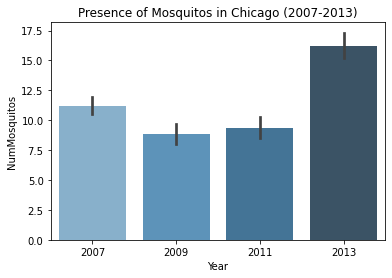

In [185]:
#presence of mosquitos across years
sns.barplot(x='Year', y='NumMosquitos', data=df, palette='Blues_d')
plt.title('Presence of Mosquitos in Chicago (2007-2013)')

Text(0.5, 1.0, 'Types of Mosquitos Recorded in the Traps')

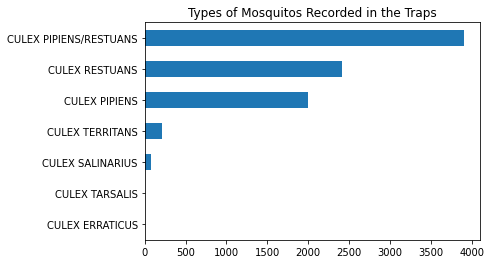

In [186]:
#Types of mosquitos discovered in the traps
df['Species'].value_counts().sort_values().plot(kind='barh')
plt.title('Types of Mosquitos Recorded in the Traps')

Text(0.5, 1.0, 'Types of Mosquitos in Wnv Positive Samples')

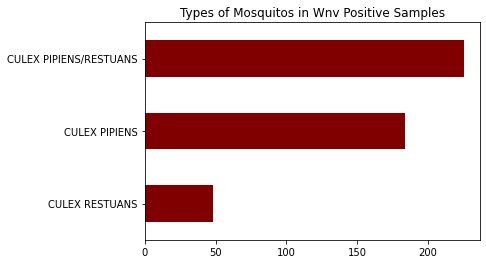

In [187]:
# Types of mosquitos identified where Wnv is positive
Wnv_present = df['Species'].where(df['WnvPresent']==1)
Wnv_present.value_counts().sort_values().plot(kind='barh', cmap='jet_r')
plt.title('Types of Mosquitos in Wnv Positive Samples')

The data suggests that Culex Pipens or Restuans were the mosquito breeds which causes Wnv in Chicago area.

Text(0.5, 1.0, '% Samples with West Nile Virus')

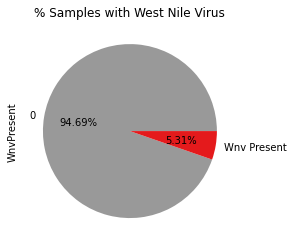

In [188]:
#Presence of WnV
labels = ['0', 'Wnv Present'] 
df['WnvPresent'].value_counts().plot(kind='pie', labels=labels, autopct='%.2f%%', cmap='Set1_r')
plt.title('% Samples with West Nile Virus')

Text(0.5, 1.0, 'Number of Mosquitos in Traps with Wnv Present (2007-2013)')

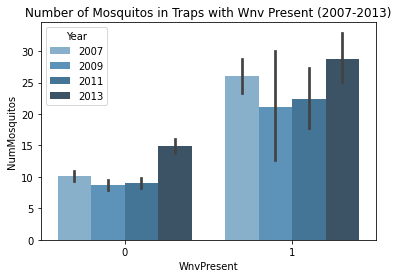

In [189]:
#Number of mosquitos in Traps where Wnv is Present
sns.barplot(x='WnvPresent', y='NumMosquitos', data=df, palette='Blues_d', hue='Year')
plt.title('Number of Mosquitos in Traps with Wnv Present (2007-2013)')

Text(0.5, 1.0, 'Number of Mosquitos in Traps vs Avg Temp (2007-2013)')

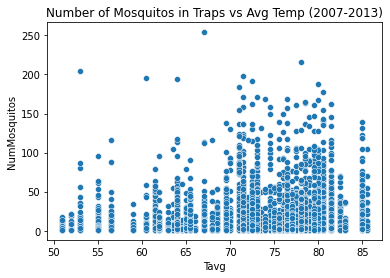

In [190]:
#Relationship between Mosquitos in Trap vs Avg Temp
sns.scatterplot(x='Tavg', y="NumMosquitos", data=df, palette='Blues_d')
plt.title('Number of Mosquitos in Traps vs Avg Temp (2007-2013)')

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6


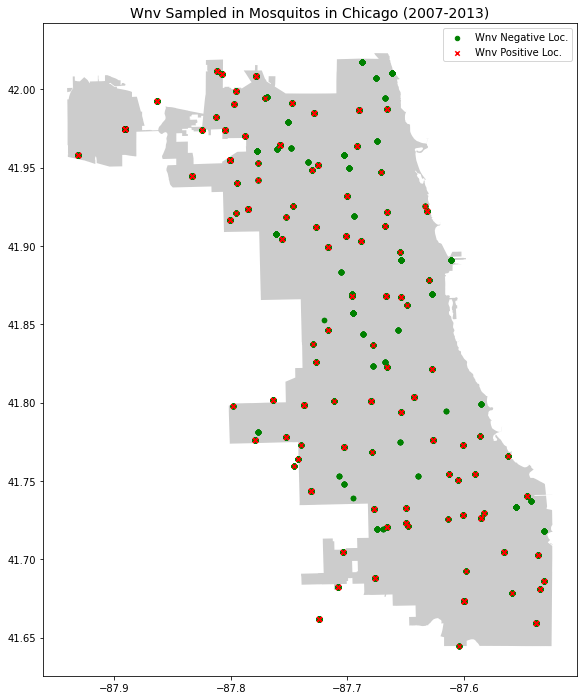

In [191]:
#Plotting the data on chicago map - map source: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-City/ewy2-6yfk)
path = '/content/drive/MyDrive/Colab Notebooks/Springboard - Data Science Career Track/7 - Capstone 2 - West Nile Virus Prediction/Data/Chicago map/geo_export_bb0e6106-48d2-4115-90e4-8a71c2244171.shp'
chicago_map = gpd.read_file(path)

#Setting Chicago  coordinates 
crs = {'init': 'epsg:4326'}

# Converting Latitude and Longitude to geo points
geo = [Point(xy) for xy in zip(train_raw['Longitude'], train_raw['Latitude'])]

# Creating a GeoDataFrame 
geo_df = gpd.GeoDataFrame(train_raw, crs=crs, geometry=geo)

# Plotting the map
fig,ax = plt.subplots(figsize = (12,12))
chicago_map.plot(ax=ax, alpha = 0.4, color='grey')
geo_df[geo_df['WnvPresent']==0].plot(ax=ax, markersize=20, color='green',marker='o', label='Wnv Negative Loc.')
geo_df[geo_df['WnvPresent']==1].plot(ax=ax, markersize=20, color='red',marker='x', label='Wnv Positive Loc.')
plt.title('Wnv Sampled in Mosquitos in Chicago (2007-2013)', fontdict={'fontsize':14})
plt.legend();

## **3) Pre-Processing & Modelling**




## **3.1) Features Engineering**




This section focuses on cleaning up and building new features from the dataset to facilitate further modelling. In summary, these tasks will be performed to improve the features to be used for model prediction: <br>


*   *Hot Coding* - hot coding the traps and mosquito breeds. Breeds which contributes to Wnv will be coded while non-Wnv breeds will be classified into "others".
*   *Trap* - transforming the trap features
*   Transforming Sunrise & Sunset timestamps into daylight duration
*   Adding new features by transofmring existing features in the dataset (e.g. max temperature + precipitation)
*   Creating time-lagged features 






**3.1.1) Hot coding Mosquito Types**

In [192]:
#one hot coding mosquito types
df['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [193]:
df['Species'] = df['Species'].replace(['CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS', 'CULEX ERRATICUS'], 'OTHERS')

In [194]:
mos_code = pd.get_dummies(df['Species'], prefix= 'Species')
mos_code.head()

,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_OTHERS
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [195]:
# changing dtype from object to int
column_headers = mos_code.columns.tolist()

for header in column_headers:
  mos_code[header] = mos_code[header].astype(int)

In [196]:
#join the dataframes together
df = df.join(mos_code, how='outer')

**3.1.2) Transforming Trap data**

In [197]:
# hot coding the 136 unique mosquito traps
lbl = preprocessing.LabelEncoder()
df['Trap'] = lbl.fit_transform(df['Trap'].values)
df['Trap'].nunique()

136

**3.1.3) Transforming Sunrise and Sunset timestamps into daylight duration**

In [198]:
#calculating the daylight duration

#cleaning up the timestamps
df['Daylight_raw'] = df['Sunset']-df['Sunrise']
df['Hours of daylight'] = df['Daylight_raw']//100
df['Minute'] = df['Daylight_raw']%100

#convert numbers into minutes
df['Daylight minutes'] = df['Hours of daylight']*60 + df['Minute']

#cleaning up the columns
df.drop(['Daylight_raw', 'Hours of daylight', 'Minute'], axis=1, inplace=True)

**3.1.4) Adding additional features into the dataset for further exploratory analysis:**

*   Maximum Temperature and precipitation
*   Maximum Temperature and pressure
*   Windspeed and wind direction
*   Relative Humidity












In [199]:
# Max Temp and precipitation
df['Tmax_Precip'] = df['Tmax']*df['PrecipTotal']

# Max Temp and pressure
df['Tmax_StnPressure'] = df['Tmax']*df['StnPressure']

# Precipitation, windspeed and direction
df['Speed_dir'] = df['ResultSpeed']*df['ResultDir']

In [200]:
#scaling the newly added features
scaler = MinMaxScaler()
df[['Tmax_Precip', 'Tmax_StnPressure', 'Speed_dir']] = scaler.fit_transform(df[['Tmax_Precip', 'Tmax_StnPressure', 'Speed_dir']])

Calculating Relative Humidity (RH) from Dew Point and Temperature Data<br>

E = 6.11*10.0**(7.5 * Dew Point Temp./(237.7 + Dew Point Temp.))<br>
Es = 6.11*10.0**(7.5 * Temp./(237.7 + Temp.))<br>
Rh = (E/Es)*100 --> to convert to percentage

In [201]:
#calculating relative humidity
df['Rh'] = ((6.11*10.0**(7.5*df['DewPoint']/(237.7+df['DewPoint'])))/(6.11*10.0**(7.5*df['Tavg']/(237.7+df['Tavg']))))

**3.1.5) Creating Time lagged features:**

*   10 day time lagged features for a selected range of features

10 day is selected as the benchmark as the life cycle of Cluex mosquitos is between 7-10 days - https://www.cdc.gov/mosquitoes/about/life-cycles/culex.html











In [202]:
# Temp + Precip 10 day lagged
df['Tmax_Precip +10'] = df['Tmax_Precip'].shift(10).replace(np.nan, 0)

# windspeed and direction - 10 day lagged
df['Speed_dir +10'] = df['Speed_dir'].shift(10).replace(np.nan,0)

# nummosquitos - 10 day lagged
df['NumMosquitos +10'] = df['NumMosquitos'].shift(10).replace(np.nan,0)


**Understanding the correlation between the features**

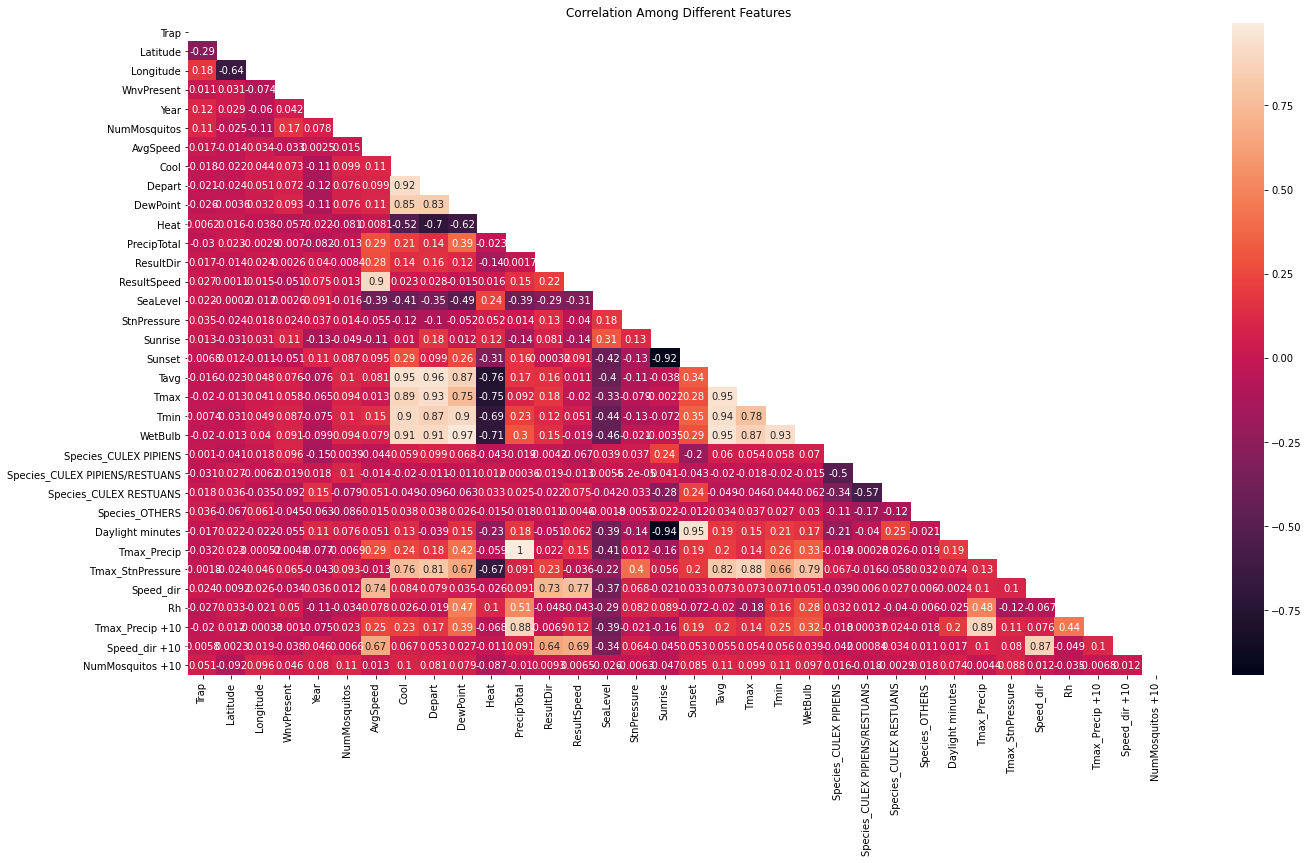

In [203]:
#understanding the correlation between the features
matrix = np.triu(df.corr())
plt.figure(figsize=(22,12))
plt.title('Correlation Among Different Features')
sns.heatmap(df.corr(), annot=True, mask=matrix)

## **3.2) Pre-Processing**




**3.2.2) Undersampling**

Since it is know that among all mosquito samples collected in the traps. There are only specific mosquito breeds which contributed to West Nile virus. To improve predictiblity of the model, records with other mosquito types were being taken out for modelling.

In [204]:
#dropping rows and columns with mosquitos not contributing to Wnv
df_moswnv = df.loc[df['Species'] != 'OTHERS']

In [205]:
df_moswnv['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS'],
      dtype=object)

In [206]:
# checking the weighting between WnvPresent and not present
df_moswnv['WnvPresent'].value_counts()

0    7847
1     457
Name: WnvPresent, dtype: int64

In [207]:
#selecting the top 40% of records with no Wnv by random sampling
df_top30 = df_moswnv[df_moswnv['WnvPresent']==0].sample(7847*30//100)

# merge random sampled dataset with records with positive Wnv
wnv_pos = df_moswnv[df_moswnv['WnvPresent']==1]
df_moswnv_rs = df_top30.append(wnv_pos)

Text(0.5, 1.0, '% Samples with West Nile Virus')

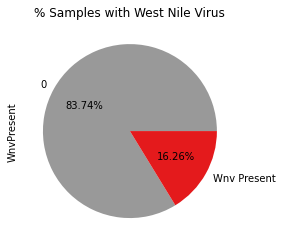

In [208]:
# re-checking the Presence of WnV
labels = ['0', 'Wnv Present'] 
df_moswnv_rs['WnvPresent'].value_counts().plot(kind='pie', labels=labels, autopct='%.2f%%', cmap='Set1_r')
plt.title('% Samples with West Nile Virus')

**3.2.2) Train/ Test Split**

In [209]:
#dropping rows and columns with mosquitos not contributing to Wnv
features_test2 = df_moswnv.drop(['Date', 'Species', 'Year-Month', 'Year-Week', 
                                'Sunrise', 'Sunset', 'Species_OTHERS'], axis=1)

In [210]:
features_test2.shape

(8304, 31)

In [211]:
features = features_test2.drop(['WnvPresent'], axis=1)

In [212]:
X = features
y = features_test2['WnvPresent']

In [213]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

**3.2.3) Examining the Predictive Power of different features & removing Colinearity**

In [214]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

Method - Variance Inflation Factor (VIF) and subsequently also test for colinearity and remove features which is less important for model prediction.

In [215]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [216]:
final_iv, IV = data_vars(X_train, y_train)

divide by zero encountered in log


In [217]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]

In [218]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
  count = 0
  while max_vif > vif_threshold:
    count += 1
    print("Iteration # "+str(count))
    vif = pd.DataFrame()
    vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns

    if vif['VIFactor'].max() > vif_threshold:
      print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
      df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
      max_vif = vif['VIFactor'].max()
    else:
      print('Complete')
      return df, vif.sort_values('VIFactor')

final_df, final_vif = iterate_vif(X_train)

Iteration # 1


divide by zero encountered in double_scalars


Removing Cool with VIF of inf
Iteration # 2
Removing Species_CULEX PIPIENS/RESTUANS with VIF of 9275874.610346
Iteration # 3
Removing Longitude with VIF of 1807160.787806
Iteration # 4
Removing Year with VIF of 897955.995011
Iteration # 5
Removing Tavg with VIF of 366342.250840
Iteration # 6
Removing Latitude with VIF of 170182.032170
Iteration # 7
Removing SeaLevel with VIF of 156546.182676
Iteration # 8
Removing DewPoint with VIF of 37305.701492
Iteration # 9
Removing WetBulb with VIF of 25730.173811
Iteration # 10
Removing Tmax with VIF of 1898.723938
Iteration # 11
Removing Tmin with VIF of 505.771643
Iteration # 12
Removing StnPressure with VIF of 337.186155
Iteration # 13
Removing Tmax_Precip with VIF of 223.479359
Iteration # 14
Removing Depart with VIF of 106.230186
Iteration # 15
Removing Daylight minutes with VIF of 70.572914
Iteration # 16
Removing AvgSpeed with VIF of 66.510273
Iteration # 17
Removing Speed_dir with VIF of 35.518001
Iteration # 18
Removing Rh with VIF of 21

In [219]:
final_df.head()

,Trap,NumMosquitos,Heat,PrecipTotal,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Speed_dir +10,NumMosquitos +10
8283,78,17,0.0,0.000,0,0,0.157370,7.0
138,7,2,0.0,0.085,0,1,0.277421,1.0
2820,112,34,1.5,0.000,0,0,0.135650,15.0
2089,85,38,0.0,0.005,1,0,0.233093,1.0
4485,71,1,3.0,0.000,0,0,0.043686,1.0


In [220]:
final_vif.sort_values(by='VIFactor', ascending=False)

,VIFactor,features
0,2.537111,Trap
6,2.040188,Speed_dir +10
5,1.472204,Species_CULEX RESTUANS
4,1.356172,Species_CULEX PIPIENS
1,1.328338,NumMosquitos
7,1.304704,NumMosquitos +10
3,1.204422,PrecipTotal
2,1.108977,Heat


**3.2.4) Building final features and Train/Test Split**

First of all, clean up required after retaining the final dataframe with only the mot important features

In [221]:
final_features = final_df.columns.tolist()

In [222]:
X = df_moswnv_rs[final_features]
y = df_moswnv_rs['WnvPresent']

In [223]:
X.shape, y.shape

((2811, 8), (2811,))

In [224]:
#scaling the data - not normally distributed therefore using MinMax Scaler
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

In [225]:
# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state=1)

## **3.3) Building the Model**




Several models will be used initially to test the effectiveness in the prediction:<br>


*   Logistic Regression
*   Random Foreset
*   K-Nearest Neighbor
*   XGBoost Classifier





**3.3.1) Logistic Regression Model**

In [226]:
# Linear Regression Model
lr = LogisticRegression(random_state=1, solver='lbfgs', max_iter=500)
lr_model = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [227]:
#Linear Regression Scores
lr_ac_train = lr.score(X_train, y_train)
lr_ac_test = lr.score(X_test, y_test)
lr_rocscore = roc_auc_score(y_test, y_pred)
lr_f1 = f1_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred, average='binary')
lr_recall = recall_score(y_test, y_pred)

print('Score - Logistic Regression:')
print(f'On Training data: {lr_ac_train.round(3)}')
print(f'On Testing data: {lr_ac_test.round(3)}')
print(f'On ROC Score: {lr_rocscore.round(3)}')
print(f'On F1 score: {lr_f1.round(3)}')
print(f'On Precision score: {lr_precision.round(3)}')
print(f'On Recall score: {lr_recall.round(3)}')

Score - Logistic Regression:
On Training data: 0.834
On Testing data: 0.835
On ROC Score: 0.519
On F1 score: 0.079
On Precision score: 0.625
On Recall score: 0.042


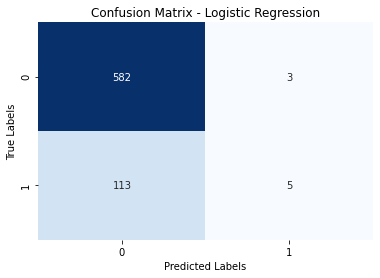

In [228]:
#Confusion matrix on test set - Non-normalized
cm = confusion_matrix(y_test, y_pred)

#ax = plt.axes()
sns.heatmap(cm, annot=True, cbar=False, fmt='g', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Text(0, 0.5, 'True Positive Rate')

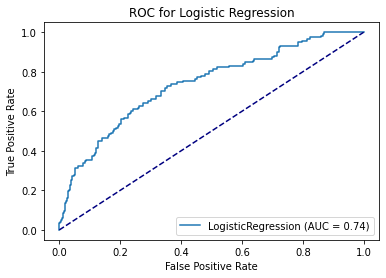

In [229]:
#ROC Curve
plot_roc_curve(lr, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC for Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

**3.3.2) Random Forest Classifier**

In [230]:
#Random Forest Model
rf = RandomForestClassifier(random_state=1)
rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [231]:
#Random Forest - Scores
rf_ac_train = rf.score(X_train, y_train) 
rf_ac_test = rf.score(X_test, y_test)
rf_rocscore = roc_auc_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average='binary')
rf_recall = recall_score(y_test, y_pred)

print('Scores - Random Forest Classifier:')
print(f'On Training data: {rf_ac_train.round(3)}')
print(f'On Testing data: {rf_ac_test.round(3)}')
print(f'On ROC Score: {rf_rocscore.round(3)}')
print(f'On F1 score: {rf_f1.round(3)}')
print(f'On Precision score: {rf_precision.round(3)}')
print(f'On Recall score: {rf_recall.round(3)}')

Scores - Random Forest Classifier:
On Training data: 1.0
On Testing data: 0.846
On ROC Score: 0.634
On F1 score: 0.407
On Precision score: 0.578
On Recall score: 0.314


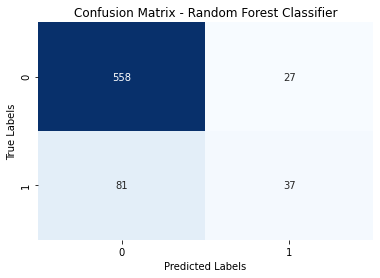

In [232]:
#Confusion matrix on test set - Non-normalized
cm = confusion_matrix(y_test, y_pred)

#ax = plt.axes()
sns.heatmap(cm, annot=True, cbar=False, fmt='g', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

Text(0, 0.5, 'True Positive Rate')

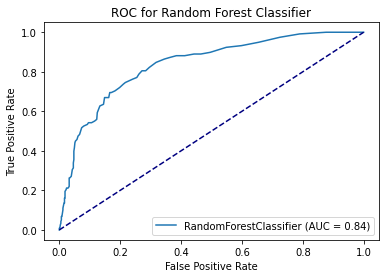

In [233]:
#ROC Curve
plot_roc_curve(rf, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC for Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

**3.3.3) K-Nearest Neighbour Classifier**

In [234]:
#KNN Classifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [235]:
#KNN Classifier Scores
knn_ac_train = knn.score(X_train, y_train) 
knn_ac_test = knn.score(X_test, y_test)
knn_rocscore = roc_auc_score(y_test, y_pred)
knn_f1 = f1_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred, average='binary')
knn_recall = recall_score(y_test, y_pred)

print('Scores - K-Nearest Neighbour Classifier:')
print(f'On Training data: {knn_ac_train.round(3)}')
print(f'On Testing data: {knn_ac_test.round(3)}')
print(f'On ROC Score: {knn_rocscore.round(3)}')
print(f'On F1 score: {knn_f1.round(3)}')
print(f'On Precision score: {knn_precision.round(3)}')
print(f'On Recall score: {knn_recall.round(3)}')

Scores - K-Nearest Neighbour Classifier:
On Training data: 0.882
On Testing data: 0.824
On ROC Score: 0.596
On F1 score: 0.326
On Precision score: 0.455
On Recall score: 0.254


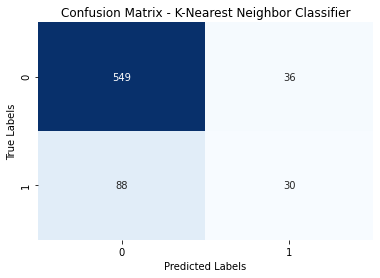

In [236]:
#Confusion matrix on test set - Non-normalized
cm = confusion_matrix(y_test, y_pred)

#ax = plt.axes()
sns.heatmap(cm, annot=True, cbar=False, fmt='g', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix - K-Nearest Neighbor Classifier')
plt.show()

Text(0, 0.5, 'True Positive Rate')

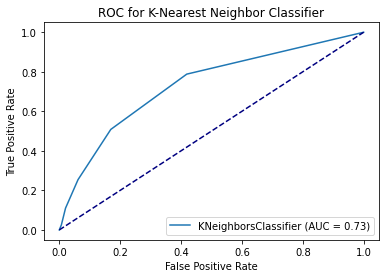

In [237]:
#ROC Curve
plot_roc_curve(knn, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC for K-Nearest Neighbor Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

**3.3.4) XGBoost Classifier**

In [238]:
#XGBoost Classifier
xgb = XGBClassifier(random_state=1)
xgb_model = xgb.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [239]:
#XGBoost Scores
xgb_ac_train = xgb.score(X_train, y_train)
xgb_ac_test = xgb.score(X_test, y_test)
xgb_rocscore = roc_auc_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred, average='binary')
xgb_recall = recall_score(y_test, y_pred)

print('Score - XGBoost Classifier:')
print(f'On Training data: {xgb_ac_train.round(3)}')
print(f'On Testing data: {xgb_ac_test.round(3)}')
print(f'On ROC Score: {xgb_rocscore.round(3)}')
print(f'On F1 score: {xgb_f1.round(3)}')
print(f'On Precision score: {xgb_precision.round(3)}')
print(f'On Recall score: {xgb_recall.round(3)}')

Score - XGBoost Classifier:
On Training data: 0.893
On Testing data: 0.858
On ROC Score: 0.664
On F1 score: 0.468
On Precision score: 0.629
On Recall score: 0.373


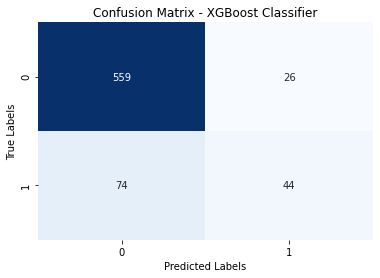

In [240]:
#Confusion matrix on test set - Non-normalized
cm = confusion_matrix(y_test, y_pred)

#ax = plt.axes()
sns.heatmap(cm, annot=True, cbar=False, fmt='g', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()

Text(0, 0.5, 'True Positive Rate')

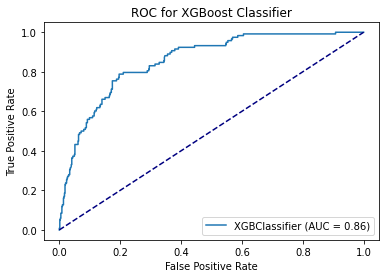

In [241]:
#ROC Curve
plot_roc_curve(xgb, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC for XGBoost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## **4) Model Evaluation & Optimization**




**4.1) Initial results from various Models**

In [242]:
model_comp = pd.DataFrame({'Metrics/ Model': ['Accuracy Score (Test data)', 'ROC Score', 'F1 Score', 'Precision Score', 'Recall'],
                           'Logistic Regression': [lr_ac_test, lr_rocscore, lr_f1, lr_precision, lr_recall],
                           'Random Forest': [rf_ac_test, rf_rocscore, rf_f1, rf_precision, rf_recall],
                           'K-Nearest Neighbor': [knn_ac_test, knn_rocscore, knn_f1, knn_precision, knn_recall],
                           'XGBoost': [xgb_ac_test, xgb_rocscore, xgb_f1, xgb_precision, xgb_recall],
                          }).round(3)

In [243]:
model_comp

,Metrics/ Model,Logistic Regression,Random Forest,K-Nearest Neighbor,XGBoost
0,Accuracy Score (Test data),0.835,0.846,0.824,0.858
1,ROC Score,0.519,0.634,0.596,0.664
2,F1 Score,0.079,0.407,0.326,0.468
3,Precision Score,0.625,0.578,0.455,0.629
4,Recall,0.042,0.314,0.254,0.373


Text(0, 0.5, 'True Positive Rate')

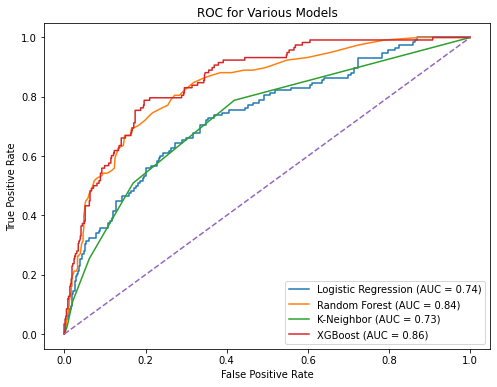

In [244]:
fig, ax = plt.subplots(figsize=(8, 6))
lr_plot = plot_roc_curve(lr, X_test, y_test, name='Logistic Regression',ax=ax)
rf_plot = plot_roc_curve(rf, X_test, y_test, name='Random Forest',ax=ax)
knn_plot = plot_roc_curve(knn, X_test, y_test, name='K-Neighbor',ax=ax)
xgb_plot = plot_roc_curve(xgb, X_test, y_test, name='XGBoost',ax=ax)
plt.plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200), label='baseline', linestyle='--')
plt.title('ROC for Various Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Among all the models tested, XGBoos yields the best accuracy and AUC scores. Further parameters tunning will be attempted to refine the model.<br>

**4.2) Parameters tuning and optimizing the Model**

In [245]:
from sklearn import model_selection, metrics

In [246]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, 
                       model, param_grid, cv=5, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test)
    else:
      pred = fitted_model.predict(X_test)
    
    return fitted_model, pred

In [261]:
xgb1 = XGBClassifier()
param_grid = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'n_estimators': [500, 800, 1000],
    'min_child_weight': [1, 5, 10], 
    'max_depth': [5, 10, 15],
}

model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, xgb1, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  3.9min finished


0.3664020068079918
{'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 500}


**4.2.1) Re-running the model with improved parameters**

In [262]:
#XGBoost Classifier (optimized parameters)
xgb_opt = XGBClassifier(learning_rate=0.01, n_estimator=500, max_depth=10, min_child_weight=10, random_state=1)
xgb_model_opt = xgb_opt.fit(X_train, y_train)
y_pred = xgb_model_opt.predict(X_test)

In [263]:
#XGBoost Scores (optimized parameters)
xgb_opt_ac_test = xgb_opt.score(X_test, y_test)
xgb_opt_rocscore = roc_auc_score(y_test, y_pred)
xgb_opt_f1 = f1_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred, average='binary')
xgb_opt_recall = recall_score(y_test, y_pred)

print('Score - XGBoost Classifier (optimized):')
print(f'On Testing data: {xgb_ac_test.round(3)}')
print(f'On ROC Score: {xgb_rocscore.round(3)}')
print(f'On F1 score: {xgb_f1.round(3)}')
print(f'On Precision score: {xgb_precision.round(3)}')
print(f'On Recall score: {xgb_recall.round(3)}')

Score - XGBoost Classifier (optimized):
On Testing data: 0.858
On ROC Score: 0.664
On F1 score: 0.468
On Precision score: 0.627
On Recall score: 0.373


Text(0, 0.5, 'True Positive Rate')

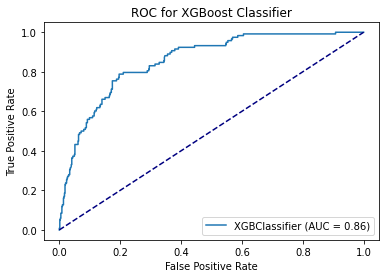

In [264]:
#ROC Curve
plot_roc_curve(xgb, X_test, y_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC for XGBoost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [265]:
from sklearn.model_selection import cross_val_score

cross_val_accuracy = cross_val_score(xgb_model_opt, X, y, scoring='accuracy', cv=5)
print('Accuracy of the model with cross-validation is: ', (np.mean(cross_val_accuracy)*100).round(2),'%')

Accuracy of the model with cross-validation is:  83.53 %


In [266]:
labels = final_df.columns.tolist()
imp_feat_score = xgb_model_opt.feature_importances_
comb_list = list(zip(labels, imp_feat_score))

feat_rank = pd.DataFrame(comb_list,columns=['labels', 'imp_feat_score']).sort_values(by='imp_feat_score', ascending=False)

Text(0.5, 1.0, 'Feature importance of the final model')

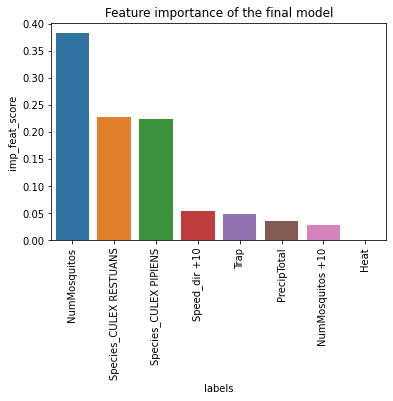

In [267]:
sns.barplot(x='labels', y='imp_feat_score', data=feat_rank)
plt.xticks(rotation=90)
plt.title('Feature importance of the final model')

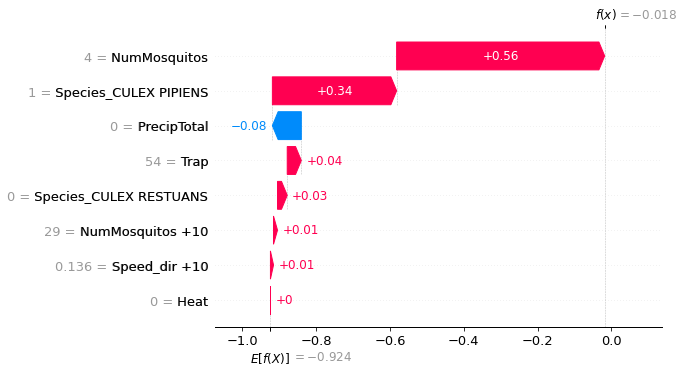

In [268]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(xgb_model_opt)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

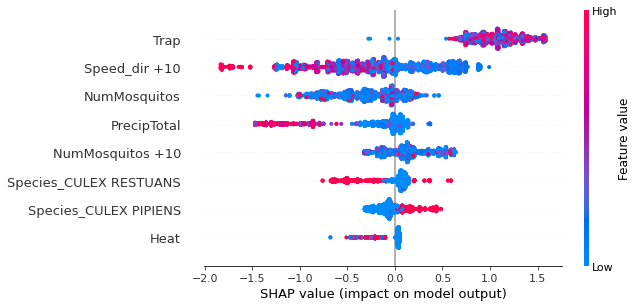

In [255]:
shap.plots.beeswarm(shap_values)

## **5) Conclusion**

Several models were analyzed in order to identify the most optimal model to predict if West Nile Virus will be predicted in the area. Models analyzed:<br>
*   Logistic Regression
*   Random Foreset
*   K-Nearest Neighbor
*   XGBoost Classifier
<br>

These models were applied towards the historic data across year 2007, 2009, 2011 and 2013 in Chicago. The model's result were then evaluated based on its accurcy score on the test data and ROC metrics.<br>

Among all models used for prediction, XGBoost Classifier yields the best predictive results. GridSearch has been performed to tune the parameters for model optimization. Final XGBoost model yields an AUC score of 0.86 with cross-validation accuracy score at 0.84.<br> 

*Limitations to the Model/ Further Considerations:*<br>
*   The model assumed the environment where sample has been collected is reltively static over the period from 2007 to 2013
*   In cleaning up the weather data - simple forward fill has been adopted in approaching station 2's missing data, a simple average has been taken between the 2 stations. If the weather station's data does vary, this may impact the model's predictibility
*   Spraying data was not considered through the modelling. This could imply an assumption which spraying does not disort the mosquito growth patterns in the training/ testing dataset 
*   Current model is built based on the most important features, either retrieved or engineered using the training and weather data.  



